# Предсказание наличия биологического ответа молекул

В ходе данной работы будут созданы модели машинного обучения, которые призваны определить наличие биологического ответа молекул (признак **Activity**) в зависимости от их химического состава (признаки **D1..D1776**).

В качестве моделей будут рассмотрены модели логичстической регрессии и случайного леса. 

При этом так же будет произведена оптимизация моделей путем применения как "простых" методов, таких как **GridSearchCV** и **RandomizedSearchCV**, так и продвинутые методы оптимизации, такие как **Hyperort** и **Optuna**. 

В качестве метрики для оценки качества модели будет использования метрика **f1-score.**

In [24]:

#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

from itertools import product # Для подсчета комбинаций в GridSearch
import time # Для подсчета времени расчетов


%matplotlib inline
plt.style.use('seaborn-v0_8')

import warnings 
warnings.filterwarnings('ignore')

## Изучение данных

### Чтение и ознакомление с данными

На данном этапе произведем чтение данных, посмотрим на основые характеристики датасета, сделаем это несколько поверхностно, т.к. по условиям данные уже "готовы". 

In [26]:
# Произведем чтение данных
data = pd.read_csv('data/_train_sem09.csv')

In [27]:
# Вывеедем два первых экземпляра
data.head(2)

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0


In [28]:
# Определим количество экземляров и признаков
data.shape

(3751, 1777)

Так как по условию задания данные уже готовы, единственное, то сделаем, небольшие проверикаи. Проверим на пропуски. 

In [29]:
data.isna().sum()[data.isna().sum() != 0]

Series([], dtype: int64)

И проверим на отсутствие категориальных признаков.

In [30]:
try:
    data.describe(include='object')
except:
    print('Категориальные признаки отсутствуют')

Категориальные признаки отсутствуют


### Корреляция

Ввиду того, что признаков очень много, интересно было бы проверить факт того, на сколько сильна корреляция предикторов с таргетом. 

Опять же, ввиду большого количества признаков строить полную тепловую карту мы не будем, сфокусируемся на данный момент на корреляции с целевым признаком. 

Воспользуемся изначально стандартной шкалой силы связи, где: 

- 0.0 - 0.3 - очень слабая

- 0.3 - 0.5 - слабая

- 0.5 - 0.7 - средняя

- 0.7 - 0.9 - сильная 

- 0.9 - 1.0 - очень сильная

Начнем со слабой связи и пойдем по возрастанию.

In [31]:
# Объект Series с данными коэфициентов корреляции признаков с целевым признаком
target_corr = data.corr()['Activity']

In [32]:
# Признаки со слабой связью с таргетом
print('Признаки со слабой слабой связью: \n{}'.format(
    target_corr[(target_corr.abs() >= 0.3) & (target_corr.abs() < 0.5)]
    ))

Признаки со слабой слабой связью: 
D27    0.47234
Name: Activity, dtype: float64


Всего один признак имеет слабую связь с целевым признаком. Немного отойдем от рекомедованной шкалы и проверим коррелицию в диапазонах **0.2 - 0.3** и **0.1 - 0.2**.

In [33]:
# Признаки с силой связи 0.2 - 0.3
print('Признаки с силой связи 0.2 - 0.3: \n{}'.format(
    target_corr[(target_corr.abs() >= 0.2) & (target_corr.abs() < 0.3)]
    ))

Признаки с силой связи 0.2 - 0.3: 
D87    -0.223081
D146    0.213311
D182    0.228664
D209    0.210154
D217   -0.233387
D469    0.268601
D596    0.204092
D607    0.210270
D659    0.226049
D660    0.204864
D747    0.226468
Name: Activity, dtype: float64


In [34]:
# Признаки с силой связи 0.1 - 0.2
print('Признаки с силой связи 0.1 - 0.2: \n{}'.format(
    target_corr[(target_corr.abs() >= 0.1) & (target_corr.abs() < 0.2)]
    ))

Признаки с силой связи 0.1 - 0.2: 
D2       0.109226
D3       0.167209
D5      -0.148447
D6      -0.106213
D7       0.137016
           ...   
D1341    0.117267
D1390    0.124877
D1434    0.125210
D1445    0.103502
D1447    0.101093
Name: Activity, Length: 140, dtype: float64


Итого, что мы имеем, 

- всего 1 признак со слабой связью
- 11 признаков с силой связи в диапазоне 0.2 - 0.3
- 140 признаков с силой связи в диапазон 0.1 - 0.2

При этом, всего предикторов 1776. То есть, на первый взгляд может сложится впечатление, что на остальные мы внимание обращать не будем. К чему эти рассуждения? Лишние данные - лишняя нагрузка на модели, возможны ложные связи. Но, прежде чем делать выводы, построим тепловую карту с этими "важными" признакми. 

Для начала, сохраним все названия полученных признаков, возможно, в дальнейшем, в рамках эксперимента, на модель подадим только эти признаки. А на данном этапе построим тепловую карту. 

Тепловая карта будет построена немного не стандартным образом, не квадратом, а прямоугольником, где на оси абсцисс будут лежать "важные" признаки, и, таргетный. По оси ординат будут вообще все признаки, прочитать мы, конечно, по такой диаграмме ничего нормально не сможем, но, возможно, какие-то мысли нам она даст. 

In [35]:
weak_corr = list(target_corr[(target_corr.abs() >= 0.3) & (target_corr.abs() < 0.5)].index)
too_weak_corr = list(target_corr[(target_corr.abs() >= 0.2) & (target_corr.abs() < 0.3)].index)
extra_weak_corr = list(target_corr[(target_corr.abs() >= 0.1) & (target_corr.abs() < 0.2)].index)

<Axes: >

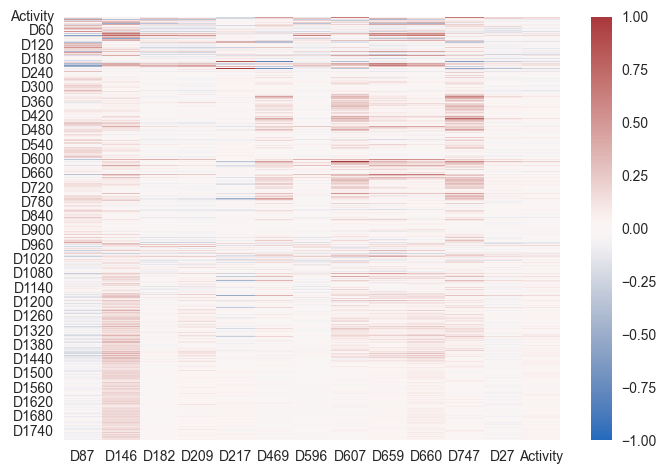

In [36]:
heat_map_list = too_weak_corr + weak_corr + ['Activity']

sns.heatmap(data.corr()[heat_map_list], center=0, vmin=-1, vmax=1, cmap='vlag')

Из данной диаграммы видны связи других признаков с "важными" признаками. Где-то, судя по всему, одни из признаков, не попавшие в "важные" имеют ощутимые связи сразу с несколькими "важными" признаками, при этом, по какой-то причине, имеют очень слабую связь с таргетным признаком. Вероятно, данное наблюдение не важно для данной конкретной работы и задачи, но, для исследователей, изучающих наличие биологического ответа молекулы (или на молекулу), возможно данное наблюдение было бы ценным. 

Мы же остановимся здесь на том, что на модель будем подавать все данные, т.к. наличие каких-то скрытых/комбинированных связей весьма вероятно. 

## Создание моделей машинного обучения

Произведем разделение данных на целевой и на предикторные признаки, а так же на тренировочную и тестовые выборки со стратификацией для избежания дисбаланса классов.

In [37]:
X = data.copy()
X = X.drop('Activity', axis=1)

y = data['Activity']

In [38]:
# Произведем разбивку на тренировную и тестовую выборки со стратификацией по целевому признаку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [39]:
# Прроверим равномерность распределения значений целевого признака в обоих выборках
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))


Activity
1    0.542333
0    0.457667
Name: proportion, dtype: float64
Activity
1    0.541944
0    0.458056
Name: proportion, dtype: float64


Какую либо визуализацию ввиду огромного количества признаков строить не имеет смысла. Так же, условием дано, что данные уже нормализованы, соответственно, так же визуализации для различных целей (например, поиск выбросов и прочее) не требуется.

## Создание базовых моделей машинного обучения

В данном блоке будут созданы модели машинного обучения на базе линейной регресии и случайного леса с параметрами по умолчанию. 

### Модель машинного обучения на базе линейной регрессии

В качестве модели используем модель логистической регрессии из библиотеки sklearn модуля linear_model.

In [40]:
lr_base_model = linear_model.LogisticRegression()

lr_base_model.fit(X_train, y_train)

y_train_pred_lr_base = lr_base_model.predict(X_train)
y_test_pred_lr_base = lr_base_model.predict(X_test)

print('F1-score для тренировочной выборки составляет {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred_lr_base)
    ))

print('F1-score для тестовой выборки составляет {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred_lr_base)
    ))

F1-score для тренировочной выборки составляет 0.89
F1-score для тестовой выборки составляет 0.79


### Модель машинного обучения на базе случайного леса

В качестве модели используем модель классификации - RandomForestClassifier из библиотеки sklearn модуля ensemble.

In [41]:
rfc_base_model = ensemble.RandomForestClassifier()

rfc_base_model.fit(X_train, y_train)

y_train_pred_rfc_base = rfc_base_model.predict(X_train)
y_test_pred_rfc_base = rfc_base_model.predict(X_test)

print('F1-score для тренировочной выборки составляет {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred_rfc_base)
    ))

print('F1-score для тестовой выборки составляет {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred_rfc_base)
    ))

F1-score для тренировочной выборки составляет 1.00
F1-score для тестовой выборки составляет 0.83


**Промежуточный вывод:**

На данный момент по полученным метрикам мы можем наблюдать, что модели, обученные с базовыми гиперпарамтерами, переобучились. Особенно это заметно на модели случайного леса, которые, без должных ограничений очень склонны к данному проявлению. И, не смотря на то, что в целом, метрики для тестовых данных получились не такие уж и плохие, тяжело назвать полученные модели устойчивыми. 

Данную проблему мы решим в следующем разделе, когда будет подбирать наилучшие гиперпараметры. 

## Подбор гиперпараметров моделей

В данном блоке будут подобраны гиперпараметры для тех же моделей. В качестве средств подбора будут использованы, как говорилось в начале, следующие методы: **GridSearchCV, RandomizedSearchCV, Hyperort, Optuna**. 

Поступим следующим образом, сначала применим все перечисленные методы поиска оптимальных гиперпараметров для модели логистической регрессии, а затем применим те же метогды к модели случайного леса.

Создадим пустой словарь, куда будем заносить информацию по метрикам и параметрам моделей, времени, обученных с разными гиперпараметрами. 

In [42]:
result_dict = {
    'ML_Model': [],
    'Optimisation_method': [],
    'Best_params': [],
    'Elapsed_time_sec': [],
    'Iteration_count': [],
    'F1_Score_train': [],
    'F1_Score_test': []
    }

### Модель машинного обучения на базе линейной регрессии

#### GridSearchCV

Условиями задачи ограничено количество итераций как 50. Но, при этом не ограничено количество использования методов. Исходя из этих требований, разделим подбор наилучних гиперпараметров в две ячейки. В первой, переберем все типы регуляризации и алгоритмы схождения. Количество комбинаций, с учетом кросс-валидации посчитаем при помощи метода product. 

Следующим шагом подберем другие гиперпараметры для полученных данных. 

In [43]:
# Задаем сетку поиска. Ввиду того, что в логрег есть типы и 
# алгоритмы, которые не работают вместе, учтем это и разобьем на варианты 
# (сделаем список словарей)
param_grid_lr = [
            {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag', 'newton-cg', 'newton-cholesky']}, # алгоритм оптимизации
              
            {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear']},

            {'penalty': ['l1', 'l2', 'none'] ,
              'solver': ['saga']},
            ]

# Передадим в метод модель, а так же параметры. 
# Так же зададим в качестве метрики f1, т.к. она у нас целевая
grid_search_lr = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid_lr, 
    cv=4, 
    n_jobs = -1,
    scoring='f1')

# Время начала работы метода
start = time.time()

# Применим метод к нашим данным, замерив время
grid_search_lr.fit(X_train, y_train)

# Время окончания работы метода и затраченное время
end = time.time()
elapsed_time = round((end - start), 2)

# Сделаем предсказания на две выборки
y_train_pred_grid_lr = grid_search_lr.predict(X_train)
y_test_pred_grid_lr = grid_search_lr.predict(X_test)

# Замерим и выведем на экран метрики по обоим выборкам
print('F1-score на тренировочной выборке составляет {:.2f}'.format(
  metrics.f1_score(y_train, y_train_pred_grid_lr)
  ))

print('F1-score на тестовой выборке составляет {:.2f}'.format(
  metrics.f1_score(y_test, y_test_pred_grid_lr)
  ))

# Выведем лучшую комбинацию гиперпараметров
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

# Расчет количества комбинаций (в данном случае итераций)
# Создаем переменную - счетчик, присваиваем 0
combinataions_counter = 0

# Т.к. словаря в сетке больше, чем один, пойдем по каждому словарю циклом
for n in range(len(param_grid_lr)):
  
  # Создаем пустой список, куда занесем из словаря сетки поиска комбинации
  list_to_count = []
  
  # Заносим значение в список для дальнейшего подсчета комбинаций
  for key in param_grid_lr[n].keys():
      list_to_count.append(list(param_grid_lr[n][key]))

  # Результат по кол-ву итераций в отдельном словаре сетки
  combinataions_counter_iter = len(list(product(*list_to_count)))
  
  # Прибавляем получившееся значение в общий счетчик
  combinataions_counter += combinataions_counter_iter

# Получившееся число итераций умножаем на кол-во фолдов
combinataions_counter = combinataions_counter*4

# Вывод результатов по кол-ву итераций и затраченному времени
print(f'Количество комбинаций: {combinataions_counter}')
print(f'Затраченное время: {elapsed_time}')

F1-score на тренировочной выборке составляет 0.87
F1-score на тестовой выборке составляет 0.79
Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'saga'}
Количество комбинаций: 52
Затраченное время: 125.98


In [44]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('LogisticRegression')
result_dict['Optimisation_method'].append('GridSearchCV_1')
result_dict['Best_params'].append(grid_search_lr.best_params_)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(combinataions_counter)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_grid_lr), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_grid_lr), 2
    ))

Итак, мы получили лучший алгоритм регуляризации **saga** тип регуляризации **l1**. И, значения метрики f1-score для тренировочной и тестовой выборок 0.88 и 0.79 соответственно. Что является небольшим улучшением по сравнению с отсутствием подобра гиперпараметров. 

Поробуем подобрать теперь параметр обратной силы регуляризации **(С)**. Зададим 12 значений параметра, 4 фолда, таким образом 48 итераций совершит метод. 

In [45]:
# Задаем сетку поиска
param_grid_lr_better = [
            {'C': list(np.linspace(0.1, 5, 12))}
            ]

# Передаем в метод оптимизации модель и сетку
grid_search_lr_better = GridSearchCV(
    estimator=linear_model.LogisticRegression(
      random_state=42, max_iter=1000, solver='saga', penalty='l1'
      ), 
    param_grid=param_grid_lr_better, 
    cv=4, 
    n_jobs=-1,
    scoring='f1')

# Время начала работы метода
start = time.time()

# Запуска метода оптимизации
grid_search_lr_better.fit(X_train, y_train)

# Время окончания работы метода и затраченное время
end = time.time()
elapsed_time = round((end - start), 2)

# Получение предсказаний по тренировочной и тестовой выборкам
y_train_pred_grid_lr_better = grid_search_lr_better.predict(X_train)
y_test_pred_grid_lr_better = grid_search_lr_better.predict(X_test)

print('F1-score на тренировочной выборке составляет {:.2f}'.format(
  metrics.f1_score(y_train, y_train_pred_grid_lr_better)
  ))

print('F1-score на тестовой выборке составляет {:.2f}'.format(
  metrics.f1_score(y_test, y_test_pred_grid_lr_better)
  ))

print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr_better.best_params_))

# Расчет количества комбинаций (в данном случае итераций)
# Создаем пустой список, куда занесем из словаря сетки поиска комбинации
list_to_count = []

for key in param_grid_lr_better[0].keys():
    list_to_count.append(list(param_grid_lr_better[0][key]))

# Результат по кол-ву итераций
combinataions_counter = len(list(product(*list_to_count)))*4

# Вывод результатов по кол-ву итераций и затраченному времени
print(f'Количество комбинаций: {combinataions_counter}')
print(f'Затраченное время: {elapsed_time}')

F1-score на тренировочной выборке составляет 0.86
F1-score на тестовой выборке составляет 0.79
Наилучшие значения гиперпараметров: {'C': 0.5454545454545455}
Количество комбинаций: 48
Затраченное время: 514.47


In [46]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('LogisticRegression')
result_dict['Optimisation_method'].append('GridSearchCV_2')
result_dict['Best_params'].append(grid_search_lr_better.best_params_)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(combinataions_counter)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_grid_lr_better), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_grid_lr_better), 2
    ))

Построим визуализацию зависимости метрики f1-score от значения параметра обратной регуляризации.

Text(0, 0.5, 'Значение метрики f1-score')

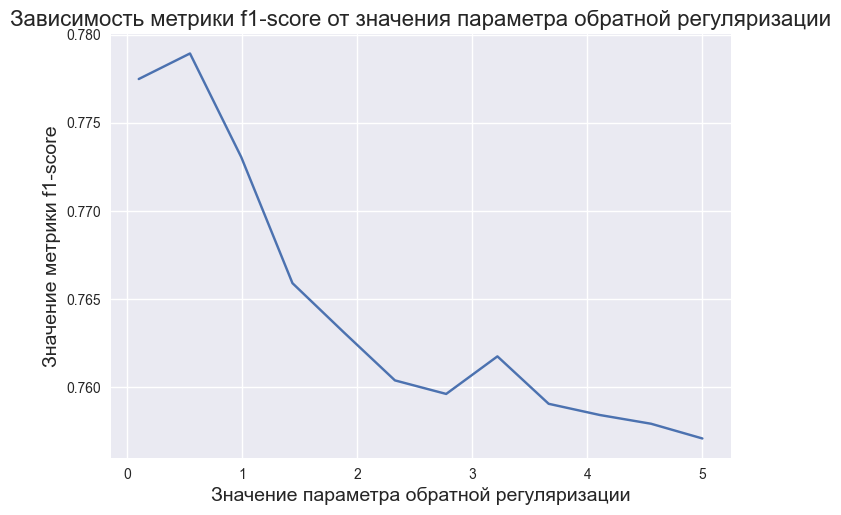

In [47]:
# Создание ДФ для визуализации (заполняем параметрами и метриками)
grid_vis_df = pd.DataFrame(grid_search_lr_better.cv_results_)

# Строим график
depend_f1_c_line = sns.lineplot(
    x=grid_vis_df['param_C'], 
    y=grid_vis_df['mean_test_score']
    )

depend_f1_c_line.set_title(
    'Зависимость метрики f1-score от значения параметра обратной регуляризации', 
    fontsize = 16
    )
depend_f1_c_line.set_xlabel(
    'Значение параметра обратной регуляризации', 
    fontsize = 14
    )
depend_f1_c_line.set_ylabel(
    'Значение метрики f1-score', 
    fontsize = 14
    )

Теперь, еще "сузим" поле поиска оптимального параметра. 

In [48]:
# Задание сетки поиска гиперпараметров
param_grid_lr_more_better = [
            {'C': list(np.linspace(0.3, 0.7, 12))}
            ]

# Передача в метод модели и сетки поиска
grid_search_lr_more_better = GridSearchCV(
    estimator=linear_model.LogisticRegression(
      random_state=42, max_iter=1000, solver='saga', penalty='l1'
      ), 
    param_grid=param_grid_lr_more_better, 
    cv=4, 
    n_jobs = -1,
    scoring='f1')

# Стартовое время начала работы метода
start = time.time()

# Применение метода оптимизации (обучение)
grid_search_lr_more_better.fit(X_train, y_train)

# Получение предсказаний модели
y_train_pred_grid_lr_more_better = grid_search_lr_more_better.predict(X_train)
y_test_pred_grid_lr_more_better = grid_search_lr_more_better.predict(X_test)

# Конечное и суммарное время работы метода
end = time.time()
elapsed_time = round((end - start), 2)

print('F1-score на тренировочной выборке составляет {:.2f}'.format(
  metrics.f1_score(y_train, y_train_pred_grid_lr_more_better)
  ))

print('F1-score на тестовой выборке составляет {:.2f}'.format(
  metrics.f1_score(y_test, y_test_pred_grid_lr_more_better)
  ))

print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr_more_better.best_params_))

# Расчет количества комбинаций (в данном случае итераций)
# Создаем пустой список, куда занесем из словаря сетки поиска комбинации
list_to_count = []

for key in param_grid_lr_more_better[0].keys():
    list_to_count.append(list(param_grid_lr_more_better[0][key]))

# Результат по кол-ву итераций
combinataions_counter = len(list(product(*list_to_count)))*4

# Вывод результатов по кол-ву итераций и затраченному времени
print(f'Количество комбинаций: {combinataions_counter}')
print(f'Затраченное время: {elapsed_time}')

F1-score на тренировочной выборке составляет 0.85
F1-score на тестовой выборке составляет 0.80
Наилучшие значения гиперпараметров: {'C': 0.5181818181818182}
Количество комбинаций: 48
Затраченное время: 531.49


In [49]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('LogisticRegression')
result_dict['Optimisation_method'].append('GridSearchCV_3')
result_dict['Best_params'].append(grid_search_lr_more_better.best_params_)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(combinataions_counter)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_grid_lr_more_better), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_grid_lr_more_better), 2
    ))

Построим визуализацию зависимости метрики f1-score от значения параметра обратной регуляризации.

Text(0, 0.5, 'Значение метрики f1-score')

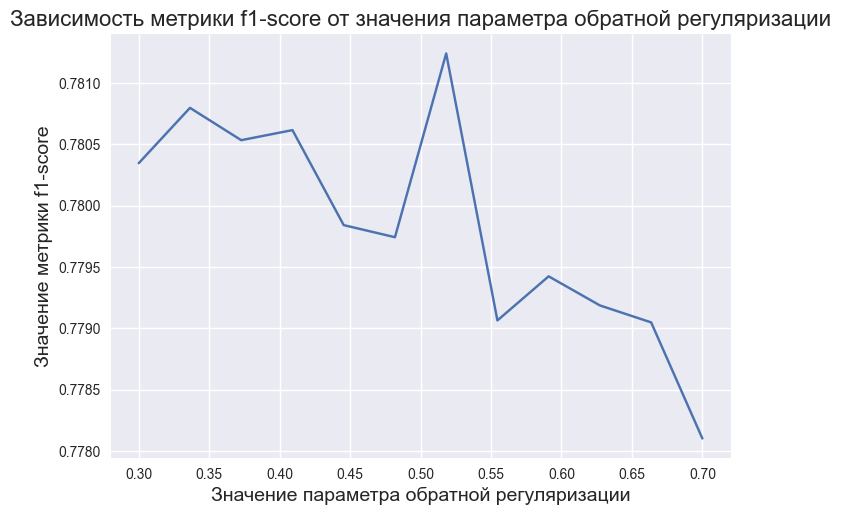

In [50]:
# СОздание ДФ для визуализации (заполняем параметрами и метриками)
grid_lr_more_better_vis_df = pd.DataFrame(grid_search_lr_more_better.cv_results_)

# Строим график
depend_f1_c_line_better_more = sns.lineplot(
    x=grid_lr_more_better_vis_df['param_C'], 
    y=grid_lr_more_better_vis_df['mean_test_score']
    )

depend_f1_c_line_better_more.set_title(
    'Зависимость метрики f1-score от значения параметра обратной регуляризации', 
    fontsize = 16
    )

depend_f1_c_line_better_more.set_xlabel(
    'Значение параметра обратной регуляризации', 
    fontsize = 14
    )
depend_f1_c_line_better_more.set_ylabel(
    'Значение метрики f1-score', 
    fontsize = 14
    )

Итак, значение метрики на тестовой выборке, путем сужения нам удалось немного улучшить, на 0.01. На тренировочной же, оценка упала на то же значение. 

Все оценки сохранены и будут сохраняться в общий словарь. По завершению наполнения словаря, можно будет произвести общий вывод по различным методам. 

### RandomizedSearchCV 

При использовании метода RandomizedSearchCV, при задании поля поиска гиперпараметров, учтем ранее полученную информацию касательно коэфициента обратной регуляризации, задавать его выше 1 не имеет смысла, значение метрики неуклонно идет вниз. 

In [51]:
# Задаем поле поиска гиперпараметров.  
param_distributions_lr = [
            {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 12, dtype=float))},

            {'penalty': ['l1', 'l2', 'none'] ,
              'solver': ['saga'],
               'C': list(np.linspace(0.01, 1, 12, dtype=float))}
            ]

# Передача в метод модели и сетки поиска
random_search_lr = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_distributions=param_distributions_lr, 
    cv=4, 
    n_iter = 50, 
    n_jobs = 3
)

# Стартовое время начала работы метода
start = time.time()

# Применение метода (обучение)
random_search_lr.fit(X_train, y_train)

# Конечное и суммарное время работы метода
end = time.time()
elapsed_time = round((end - start), 2)

y_train_pred_lr_rand = random_search_lr.predict(X_train)
y_test_pred_lr_rand = random_search_lr.predict(X_test)

print('F1-score на тренировочной выборке составляет {:.2f}'.format(
  metrics.f1_score(y_train, y_train_pred_lr_rand)
  ))

print('F1-score на тестовой выборке составляет {:.2f}'.format(
  metrics.f1_score(y_test, y_test_pred_lr_rand)
  ))

print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))

# Вывод результатов по кол-ву итераций и затраченному времени
print(f'Затраченное время: {elapsed_time}')

F1-score на тренировочной выборке составляет 0.85
F1-score на тестовой выборке составляет 0.80
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.09999999999999999}
Затраченное время: 625.81


In [52]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('LogisticRegression')
result_dict['Optimisation_method'].append('RandomizedSearchCV')
result_dict['Best_params'].append(random_search_lr.best_params_)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(50)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_lr_rand), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_lr_rand), 2
    ))

Произведем визуализацию полученных метрик в разрезе комбинаций гиперпараметров.

In [53]:
# Создадим ДФ для визуализации 
random_search_lr_vis_df = pd.DataFrame(random_search_lr.cv_results_)

# Создадим новый признак, который будем использовать для визуализации - 
# комбинация алгоритма оптимизации и типа регуляризации
random_search_lr_vis_df['solver_penalty'] = \
    random_search_lr_vis_df['param_solver'] + ' - ' + random_search_lr_vis_df['param_penalty']

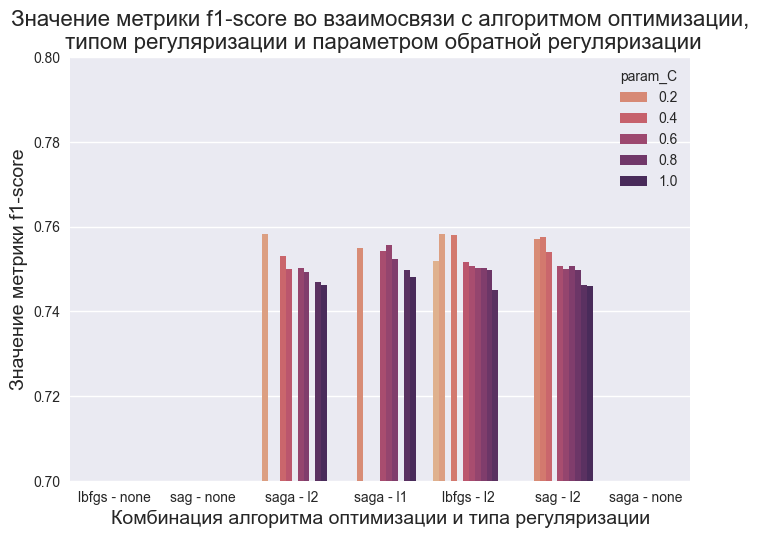

In [54]:
# Задаем параметры для построения барплота
depend_c_solver_penalty_f1_lr_bar = sns.barplot(
    data = random_search_lr_vis_df,
    x = 'solver_penalty',
    y = 'mean_test_score', 
    hue = 'param_C',
    palette='flare'
    )

# Выставим границы оси ординат для лучшей читаемости графика
depend_c_solver_penalty_f1_lr_bar.set_ylim(0.7, 0.8)

# Наносим текстовые сопровождения
depend_c_solver_penalty_f1_lr_bar.set_title(
    'Значение метрики f1-score во взаимосвязи с алгоритмом оптимизации,' +
    '\n типом регуляризации и параметром обратной регуляризации', 
    fontsize = 16
    )

depend_c_solver_penalty_f1_lr_bar.set_ylabel(
    'Значение метрики f1-score', 
    fontsize = 14
    )

depend_c_solver_penalty_f1_lr_bar.set_xlabel(
    'Комбинация алгоритма оптимизации и типа регуляризации', 
    fontsize = 14
    );


**Промежуточный вывод:**

При применении метода RandomSearchCV полученные метрики **совпадают** с метриками, полученными при применении сетки поиска гиперпараметров. При этом, на вычисления было затрачено **почти в три раза меньше** времени. 

Так же, по построенно столбачтой диаграмме можно увидеть, что, видимо в силу ограничения на 50 итераций, данный метод на "зашел" в поиск а часть комбинаций алгоритма оптимизации и типа регуляризации. Но, опираясь на результаты поиска при помощи сетки гиперпараметров, можно сделать предположение, о том, что в данных комбинациях лучшего результата не будет. 

### Hyperopt


Теперь произведем подбор гиперпараметров при помощи метода Hyperopt.

In [55]:
# зададим пространство поиска гиперпараметров. Так же задаем список словарей
# Для предупреждения конфликта при работе метода имена гиперпараметров снабжены индексами
# В дальнейшем, имена будут дешефрованы к тому виду, что требует модель
# Так же добавлен алгоритм выбора набора из поля поиска гиперпараметров (model_type)
space_lr_hyper = hp.choice('model_type', [
    {
        'penalty': hp.choice('penalty1', ['l2', None]),
        'solver': hp.choice('solver1', ['lbfgs', 'sag']),
        'C': hp.loguniform('C1', -7, 0)
    },
    {
        'penalty': hp.choice('penalty2', ['l1', 'l2', None]),
        'solver': hp.choice('solver2', ['saga']),
        'C': hp.loguniform('C2', -7, 0)
    }
])

def hyperopt_lr(params, cv=4, X=X_train, y=y_train, random_state=42):

    model = linear_model.LogisticRegression(**params, random_state=random_state)
    model.fit(X, y)
    preds = model.predict(X)
    score = metrics.f1_score(y, preds)
    
    # Возвращаем отрицательное значение метрики, т.к. hyperopt минимизирует функцию
    return -score

In [56]:
# Время начала работы метода
start = time.time()

# Логтирование результатов
trials_lr = Trials()

# Передача в метод функции, параметров, запуск метода
best_lr_hyper = fmin(
    fn=hyperopt_lr,
    space=space_lr_hyper,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_lr,
    rstate=np.random.default_rng(42)
    )

# Время окончания работы метода и затраченное время
end = time.time()
elapsed_time = round((end - start), 2)

print("Лучшие гиперпараметры:", best_lr_hyper)

100%|██████████| 50/50 [01:32<00:00,  1.85s/trial, best loss: -0.9072543617998163]
Лучшие гиперпараметры: {'C1': 0.1714009741617408, 'model_type': 0, 'penalty1': 1, 'solver1': 0}


In [57]:
# Произведем декодирование найденных лучших гиперпараметров 

# Задаем словари, из которых будем брать значения гиперпараметров в результате дешефровки
penalty1_options = ['l2', None]
solver1_options = ['lbfgs', 'sag']

penalty2_options = ['l1', 'l2', None]
solver2_options = ['saga']

# Функция для преобразования индексов в значения
def decode_best_params(best):
    
    model_type = best['model_type']
    
    if model_type == 0:
        params = {
            'penalty': penalty1_options[best['penalty1']],
            'solver': solver1_options[best['solver1']],
            'C': best['C1']
        }
    else:
        params = {
            'penalty': penalty2_options[best['penalty2']],
            'solver': solver2_options[best['solver2']],
            'C': best['C2']
        }
    return params

# Словарь с полученными лучшими гиперпараметрами
decoded_params = decode_best_params(best_lr_hyper)

In [58]:
# Модель, передаем в нее полученные гиперпараметры
model_lr_hyper = linear_model.LogisticRegression(
    random_state=42, 
    **decoded_params
)

# Обучаем модель, делаем предсказания
model_lr_hyper.fit(X_train, y_train)

y_train_lr_hyper_pred = model_lr_hyper.predict(X_train)
y_test_lr_hyper_pred = model_lr_hyper.predict(X_test)

# Считаем метрики, выводим результат
print('f1_score на тенировочной выборке: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_lr_hyper_pred))
      )
print('f1_score на тестовой выборке: {:.2f}'.format(
    metrics.f1_score(y_test, y_test_lr_hyper_pred))
      )
print(f'Затраченное время: {elapsed_time}')


f1_score на тенировочной выборке: 0.91
f1_score на тестовой выборке: 0.78
Затраченное время: 92.4


In [59]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('LogisticRegression')
result_dict['Optimisation_method'].append('Hyperopt')
result_dict['Best_params'].append(decoded_params)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(50)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_lr_hyper_pred), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_lr_hyper_pred), 2
    ))

Произведем визуализацию полученных гиперпараметров и оценки точности при обучении модели. 

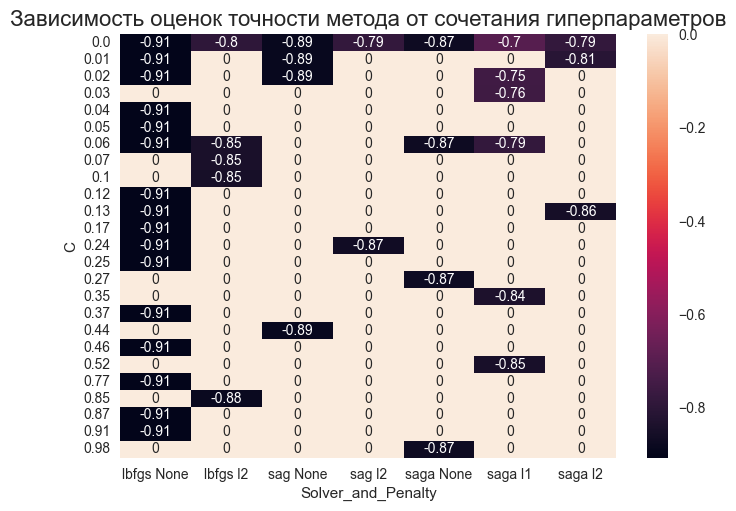

In [60]:
# Подготовим данные. 
# Функции для "декодирования" индексов параметров в их названия
def penalty_decode(penalty_values):
    """Преобразование индекса типа регуляризации
        в название типа

    Args:
        penalty_values (tuple): индекс из первого и второго словаря 
        поля поиска гиперпараметров (один из них будет пустой)

    Returns:
        str: итоговое название типа 
        """
        
    if len(penalty_values[0]) != 0:
        return penalty1_options[penalty_values[0][0]]
    else:
        return penalty2_options[penalty_values[1][0]]


def solver_decode(solver_values):
    """Преобразование индекса метода оптимизации
        в название метода

    Args:
        solver_values (tuple): индекс из первого и второго словаря 
        поля поиска гиперпараметров (один из них будет пустой)

    Returns:
        str: итоговое название метода 
    """
    if len(solver_values[0]) != 0:
        return solver1_options[solver_values[0][0]]
    else:
        return solver2_options[solver_values[1][0]]

# Создадим массив нужных данных (гиперпараметры и оценки точности)
# В процессе формирования задействуем функции для декодирования
tpe_results_lr=np.array([[
                    
                    x['result']['loss'],
                    round((x['misc']['vals']['C1'] + x['misc']['vals']['C2'])[0], 2),
                    penalty_decode((x['misc']['vals']['penalty1'], x['misc']['vals']['penalty2'])),
                    solver_decode((x['misc']['vals']['solver1'], x['misc']['vals']['solver2']))
                    ]
                    for x in trials_lr.trials]
                    )

# Создадим ДФ
tpe_results_lr_df=pd.DataFrame(tpe_results_lr,
                           columns=['score', 'C', 'penalty', 'solver'])

# Ввиду того, что у нас есть и категориальные признаки, здесь мы выберем 
# к построению тепловую карту, сформируем для нее сводную таблицу 
# Сначала преобразуем признак метода оптимизации и типа рег-ии в один признак
tpe_results_lr_df['Solver_and_Penalty'] = \
    tpe_results_lr_df['solver'].astype(str) + ' ' + tpe_results_lr_df['penalty'].astype(str)

# Удалим лишние признаки
tpe_results_lr_df = tpe_results_lr_df.drop('penalty', axis=1)
tpe_results_lr_df = tpe_results_lr_df.drop('solver', axis=1)

# Создаем сводную таблицу
tpe_results_pivot = tpe_results_lr_df.pivot_table(
    index='C',
    columns='Solver_and_Penalty',
    values='score',
    aggfunc='mean'
)

# Заполняем пропуски нулями (а в силу малого кол-ва итераций их будет много)
tpe_results_pivot = tpe_results_pivot.fillna(0)

# Строим тепловую карту
hyperopt_lr_heatmap = sns.heatmap(tpe_results_pivot, annot=True)
hyperopt_lr_heatmap.set_title(
    'Зависимость оценок точности метода от сочетания гиперпараметров',
    fontsize=16);

#### Optuna

In [61]:
# Функция для оптимизации гиперпараметров для модели случайного леса
def optuna_lr(trial):
    
    # задаем пространства поиска гиперпараметров
    # Как и в предыдущих методах делаем разбиение, ввиду несовместимости некоторых 
    # типов и методов
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sag', 'saga'])

    if solver == 'saga':
        penalty = trial.suggest_categorical('penalty_saga', ['l1', 'l2', 'none'])
    else:
        penalty = trial.suggest_categorical('penalty_other', ['l2', 'none'])

    # Сопоставление строкового значения 'none' с None
    if penalty == 'none':
        penalty = None

    C = trial.suggest_float('C', 0.01, 10.0, step=0.01)

    # Задаем модель
    model = linear_model.LogisticRegression(
        solver=solver,
        penalty=penalty,
        C=C,
        max_iter=50,
        random_state=42
    )

    # Т.к. в данном методе кросс-валидации по умолчанию нет, 
    # пропишем ее вручную, с теми же параметрами, что и в других методах
    cv = KFold(n_splits=4, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')


    return np.mean(scores)


In [62]:
# Заглушка для текстового вывода результатов работы каждой итерации оптимизации
optuna.logging.disable_default_handler()

# Начало работы оптимизации
start = time.time()

# cоздаем объект исследования, максимизируем метрику direction="maximize"
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=50);

# Время окончания работы оптимизации
end = time.time()

# Затраченное время
elapsed_time = round((end - start), 2)

In [63]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lr.best_value))
print(f'Затраченное время: {elapsed_time}')

Наилучшие значения гиперпараметров {'solver': 'sag', 'penalty_other': 'l2', 'C': 0.060000000000000005}
f1_score на обучающем наборе: 0.78
Затраченное время: 261.16


Так как нам потребовался "костыль" в виде разбиения названия типа регуляризации,  study_lr.best_params в том виде, в котором он есть не может быть подан на модель. 

Сделаем вспомогательный словарь - копию, и переименуем в нем название ключа, ответственного за данный параметр на тот, что примет модель. И уже его подадим в модель.

In [64]:
params_dict = study_lr.best_params.copy()

# Имеем два возвожных имени типа регул-ии, воспользуемся обработчиком исключений
try:
    params_dict['penalty'] = params_dict.pop('penalty_other')
except:
    params_dict['penalty'] = params_dict.pop('penalty_saga')    

In [65]:
# рассчитаем точность для тестовой выборки
model_optuna_lr = linear_model.LogisticRegression(**params_dict, random_state=42)
model_optuna_lr.fit(X_train, y_train)
y_train_pred_optuns_lr = model_optuna_lr.predict(X_train)
print("f1_score на тренировочном наборе: {:.2f}".format(metrics.f1_score(y_train, y_train_pred_optuns_lr)))
y_test_pred_optuns_lr = model_optuna_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_optuns_lr)))

f1_score на тренировочном наборе: 0.84
f1_score на тестовом наборе: 0.80


In [66]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('LogisticRegression')
result_dict['Optimisation_method'].append('Optuna')
result_dict['Best_params'].append(params_dict)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(50)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_optuns_lr), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_optuns_lr), 2
    ))

Визуализируем результаты оптимизации. 

Первым построим диаграмму для проверки верности направления (в нашей случае метрика должна максимизироваться).

In [67]:
optuna.visualization.plot_optimization_history(study_lr, target_name="f1_score")

Все корректно, метрика растет. 

Теперь проверим какие гиперпараметры играют бОльшую значимость для метрики.

In [68]:
optuna.visualization.plot_param_importances(study_lr, target_name="f1_score")

Мы видим, что самый важный параметр - это алгоритм оптимизации. 

Построим график для двух важных параметров, иллюстрирующую взаимосвязь параметров и метрики, solver и C, обратного коэффициента регуляризации.

In [69]:
optuna.visualization.plot_contour(study_lr, params=["solver", "C"],
                                  target_name="f1_score")

### Модель машинного обучения на базе случайного леса

Теперь займемся подбором гиперпараметров для модели машинного обучения на базе случайного леса. Применим те же методы оптимизации.

#### GridSearchCV

In [70]:
# Задание сетки поиска гиперпараметров
param_grid_rf = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.linspace(5, 50, 5, dtype=int),
    'min_samples_leaf': np.linspace(5, 12, 3, dtype=int),
    }

# Передача в метод модели и сетки поиска
grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    cv=4,
    n_jobs=3,
    scoring='f1'
)

# Стартовое время начала работы метода
start = time.time()

# Применение метода (обучение)
grid_search_rf.fit(X_train, y_train)

# Конечное время работы метода
end = time.time()
# Суммарное время работы метода
elapsed_time = round((end - start), 2)

# Получение предсказаний модели
y_train_pred_rf_grid = grid_search_rf.predict(X_train)
y_test_pred_rf_grid = grid_search_rf.predict(X_test)

# Вывод результатов на печать (метрики, лучшие параметры)
print('F1-score на тренировочной выборке составляет {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred_rf_grid)
    ))

print('F1-score на тестовой выборке составляет {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred_rf_grid)
    ))

print('Наилучашие значения гиперпараметров: {}'.format(
    grid_search_rf.best_params_
    ))

# Расчет количества комбинаций (в данном случае итераций)
list_to_count = []

for key in param_grid_rf.keys():
    list_to_count.append(list(param_grid_rf[key]))

# Результат по кол-ву итераций
combinataions_counter = len(list(product(*list_to_count)))

# Вывод результатов по кол-ву итераций и затраченному времени
print(f'Количество комбинаций: {combinataions_counter}')
print(f'Затраченное время: {elapsed_time}')

F1-score на тренировочной выборке составляет 0.95
F1-score на тестовой выборке составляет 0.82
Наилучашие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 27, 'min_samples_leaf': 5}
Количество комбинаций: 45
Затраченное время: 75.29


In [71]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('RandomForestClassifier')
result_dict['Optimisation_method'].append('GridSearchCV')
result_dict['Best_params'].append(grid_search_rf.best_params_)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(combinataions_counter)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_rf_grid), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_rf_grid), 2
    ))

Сузим наш поиск

In [72]:
# Задание сетки поиска гиперпараметров
param_grid_rf_better = {
    'criterion': ['entropy'],
    'max_depth': np.arange(30, 110, 10),
    'min_samples_leaf': np.arange(1, 7, 1),
    
    }

# Передача в метод модели и сетки поиска
grid_search_rf_better = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf_better,
    cv=4,
    n_jobs=-1,
    scoring='f1'
)

# Стартовое время начала работы метода
start = time.time()

# Применение метода (обучение)
grid_search_rf_better.fit(X_train, y_train)

# Конечное и суммарное время работы метода
end = time.time()
elapsed_time = round((end - start), 2)

# Получение предсказаний модели
y_train_pred_rf_grid_better = grid_search_rf_better.predict(X_train)
y_test_pred_rf_grid_better = grid_search_rf_better.predict(X_test)

# Вывод результатов на печать (метрики, лучшие параметры)
print('F1-score на тренировочной выборке составляет {:.2f}'.format(
    metrics.f1_score(y_train, y_train_pred_rf_grid_better)
    ))

print('F1-score на тестовой выборке составляет {:.2f}'.format(
    metrics.f1_score(y_test, y_test_pred_rf_grid_better)
    ))

print('Наилучашие значения гиперпараметров: {}'.format(
    grid_search_rf_better.best_params_
    ))

# Расчет количества комбинаций (в данном случае итераций)
# Создаем пустой список, куда занесем из словаря сетки поиска комбинации
list_to_count = []

for key in param_grid_rf_better.keys():
    list_to_count.append(list(param_grid_rf_better[key]))

# Результат по кол-ву итераций
combinataions_counter = len(list(product(*list_to_count)))

# Вывод результатов по кол-ву итераций и затраченному времени
print(f'Количество комбинаций: {combinataions_counter}')
print(f'Затраченное время: {elapsed_time}')

F1-score на тренировочной выборке составляет 1.00
F1-score на тестовой выборке составляет 0.83
Наилучашие значения гиперпараметров: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1}
Количество комбинаций: 48
Затраченное время: 70.72


In [73]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('RandomForestClassifier')
result_dict['Optimisation_method'].append('GridSearchCV_2')
result_dict['Best_params'].append(grid_search_rf_better.best_params_)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(combinataions_counter)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_rf_grid_better), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_rf_grid_better), 2
    ))

Визуилизируем связи полученных гиперпараметров и метрики.

Построим график зависимости метрики f1-score от максимальной глубины дерева. 

Text(0, 0.5, 'Значение метрики f1-score')

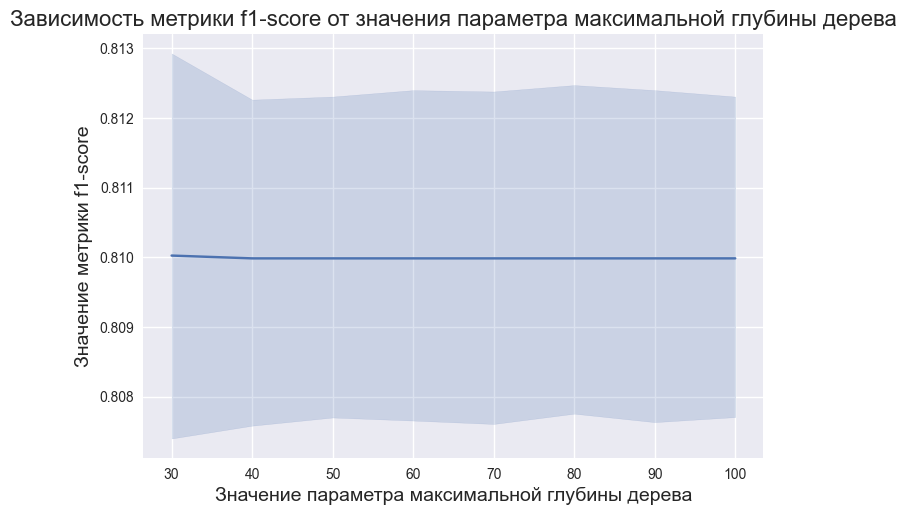

In [74]:
# СОздание ДФ для визуализации (заполняем параметрами и метриками)
grid_vis_df = pd.DataFrame(grid_search_rf_better.cv_results_)

# Строим график
depend_f1_max_depth_line = sns.lineplot(
    x=grid_vis_df['param_max_depth'], 
    y=grid_vis_df['mean_test_score']
    )

depend_f1_max_depth_line.set_title(
    'Зависимость метрики f1-score от значения параметра максимальной глубины дерева', 
    fontsize = 16
    )
depend_f1_max_depth_line.set_xlabel(
    'Значение параметра максимальной глубины дерева', 
    fontsize = 14
    )
depend_f1_max_depth_line.set_ylabel(
    'Значение метрики f1-score', 
    fontsize = 14
    )

Построим график зависимости метрики f1-score от минимального числа объектов в листе дерева. 

Text(0, 0.5, 'Значение метрики f1-score')

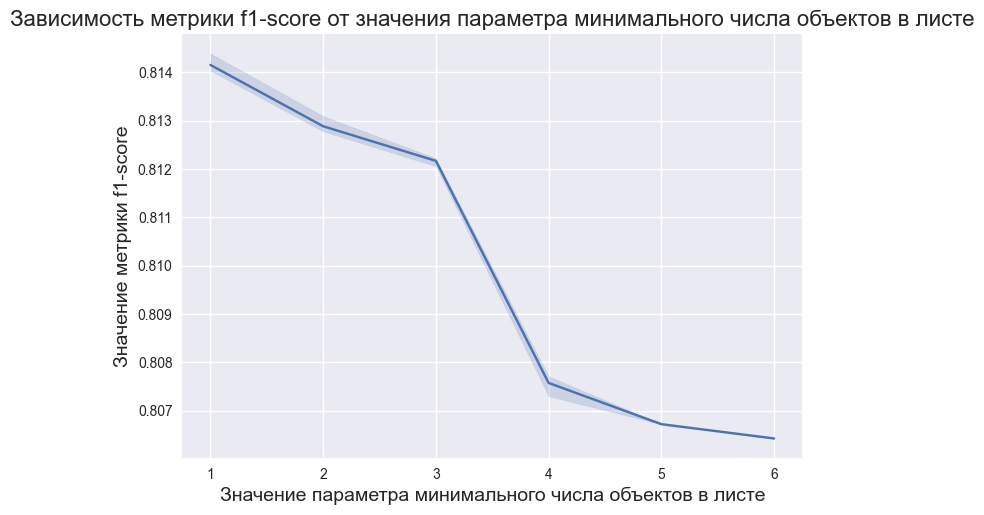

In [75]:
depend_f1_min_samples_leaf_line = sns.lineplot(
    x=grid_vis_df['param_min_samples_leaf'], 
    y=grid_vis_df['mean_test_score']
    )

depend_f1_min_samples_leaf_line.set_title(
    'Зависимость метрики f1-score от значения параметра минимального числа объектов в листе', 
    fontsize = 16
    )
depend_f1_min_samples_leaf_line.set_xlabel(
    'Значение параметра минимального числа объектов в листе', 
    fontsize = 14
    )
depend_f1_min_samples_leaf_line.set_ylabel(
    'Значение метрики f1-score', 
    fontsize = 14
    )

### RandomizedSearchCV 

In [77]:
#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': np.arange(10, 150, 10),
    'min_samples_leaf': np.arange(1, 10, 1)
    }
            
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=4, 
    n_iter = 50, 
    n_jobs = -1
    )

start = time.time() 

random_search_rf.fit(X_train, y_train)

end = time.time()
elapsed_time = np.round((end - start), 2)

y_train_pred_rf_rand = random_search_rf.predict(X_train)
y_test_pred_rf_rand = random_search_rf.predict(X_test)

print('F1-score на тренировочной выборке составляет {:.2f}'.format(
  metrics.f1_score(y_train, y_train_pred_rf_rand)
  ))

print('F1-score на тестовой выборке составляет {:.2f}'.format(
  metrics.f1_score(y_test, y_test_pred_rf_rand)
  ))

print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))
print(f'Затраченное время: {elapsed_time}')

F1-score на тренировочной выборке составляет 1.00
F1-score на тестовой выборке составляет 0.83
Наилучшие значения гиперпараметров: {'min_samples_leaf': 1, 'max_depth': 110, 'criterion': 'entropy'}
Затраченное время: 53.81


In [78]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('RandomForestClassifier')
result_dict['Optimisation_method'].append('RandomizedSearchCV')
result_dict['Best_params'].append(random_search_rf.best_params_)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(50)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_rf_rand), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_rf_rand), 2
    ))

Визуализируем полученные данные метрик во взаимосвязи с вариантами гиперпараметров. 

Для этого создадим отдельный DataFrame, куда занесем нужную нам информацию.

In [79]:
# Создадим ДФ для визуализации 
random_search_rf_vis_df = pd.DataFrame(random_search_rf.cv_results_)

# Создадим новый признак, который будем использовать для визуализации - 
# комбинация критерия и глубины дерева
random_search_rf_vis_df['criterion_max_depth'] = \
    random_search_rf_vis_df['param_criterion'] + ' - ' + \
        random_search_rf_vis_df['param_max_depth'].astype('str')

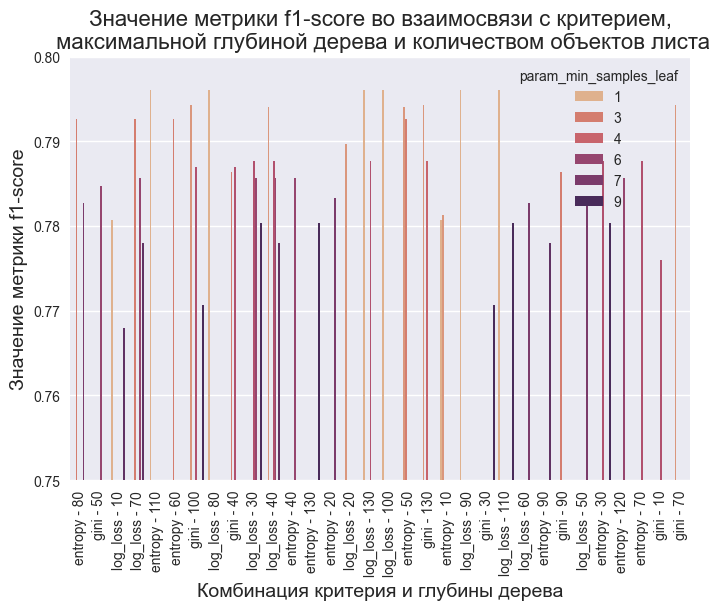

In [80]:
# Задаем параметры для построения барплота
depend_leaf_depth_criterion_rf_f1_bar = sns.barplot(
    data = random_search_rf_vis_df,
    x = 'criterion_max_depth',
    y = 'mean_test_score', 
    hue = 'param_min_samples_leaf',
    palette='flare'
    )

# Выставим границы оси ординат для лучшей читаемости графика
depend_leaf_depth_criterion_rf_f1_bar.set_ylim(0.75, 0.8)

# Наносим текстовые сопровождения
depend_leaf_depth_criterion_rf_f1_bar.set_title(
    'Значение метрики f1-score во взаимосвязи с критерием,' +
    '\n максимальной глубиной дерева и количеством объектов листа', 
    fontsize = 16
    )

depend_leaf_depth_criterion_rf_f1_bar.set_ylabel(
    'Значение метрики f1-score', 
    fontsize = 14
    )

depend_leaf_depth_criterion_rf_f1_bar.set_xlabel(
    'Комбинация критерия и глубины дерева', 
    fontsize = 14,
    )


plt.xticks(rotation=90);

### Hyperopt

In [81]:
# зададим пространство поиска гиперпараметров
space={'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
       'max_depth' : hp.quniform('max_depth', 10, 150, 10),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
      }

In [82]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(space, cv=4, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'criterion': space['criterion'], 
              'max_depth': int(space['max_depth']), 
             'min_samples_leaf': int(space['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [83]:
start = time.time()
# начинаем подбор гиперпараметров

trials = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

end = time.time()
elapsed_time = round((end - start), 2)
print("Наилучшие значения гиперпараметров {}".format(best_rf))
print(f'Затраченное время: {elapsed_time}')

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 50/50 [02:21<00:00,  2.83s/trial, best loss: -0.8164994161044827]
Наилучшие значения гиперпараметров {'criterion': 2, 'max_depth': 20.0, 'min_samples_leaf': 1.0}
Затраченное время: 141.45


In [84]:
# рассчитаем точность для тестовой выборки
model_rf_hyper = ensemble.RandomForestClassifier(
    random_state=random_state, 
    criterion = 'entropy',
    max_depth = int(best_rf['max_depth']),
    min_samples_leaf = int(best_rf['min_samples_leaf'])
)

model_rf_hyper.fit(X_train, y_train)

y_train_rf_hyper_pred = model_rf_hyper.predict(X_train)
y_test_rf_hyper_pred = model_rf_hyper.predict(X_test)

print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_rf_hyper_pred))
      )
print('f1_score на тестовом наборе: {:.2f}'.format
      (metrics.f1_score(y_test, y_test_rf_hyper_pred))
      )

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.82


Мы получили хорошую метрику на тестовом наборе данных. Однако, метрика на тренировочном наборе данных равняется единице. Следовательно, наша модель переобучена. Так же, на это указывает тот факт, что оптимальным параметром минимального количества объектов в листе, метод принял единице. Т.е. он в результате работы метода подбора гиперпараметров каждый образец из тренировочной выборки был предсказан верно. 

Снизим диапазон для данного гиперпараметра и произведем повторное обучение. 

In [85]:
# зададим пространство поиска гиперпараметров
space={'criterion': hp.choice('criterion', ['gini', 'entropy', 'log_loss']),
       'max_depth' : hp.quniform('max_depth', 10, 150, 10),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 4, 10, 1)
      }

In [86]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(space, cv=4, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'criterion': space['criterion'], 
              'max_depth': int(space['max_depth']), 
             'min_samples_leaf': int(space['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [87]:
# Время начала работы метода
start = time.time()

# начинаем подбор гиперпараметров

trials_rf = Trials() # используется для логирования результатов

best_rf=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию
          max_evals=50, # максимальное количество итераций
          trials=trials_rf, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )

# Время окончания работы метода и затраченное время
end = time.time()
elapsed_time = round((end - start), 2)

# Вывод результатов
print("Наилучшие значения гиперпараметров {}".format(best_rf))
print(f'Затраченное время: {elapsed_time}')

100%|██████████| 50/50 [02:08<00:00,  2.57s/trial, best loss: -0.807712409271886] 
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 80.0, 'min_samples_leaf': 4.0}
Затраченное время: 128.52


In [88]:
# рассчитаем точность для тестовой выборки
model_rf_hyper = ensemble.RandomForestClassifier(
    random_state=random_state, 
    criterion = 'entropy',
    max_depth = int(best_rf['max_depth']),
    min_samples_leaf = int(best_rf['min_samples_leaf'])
)

model_rf_hyper.fit(X_train, y_train)

y_train_rf_hyper_pred = model_rf_hyper.predict(X_train)
y_test_rf_hyper_pred = model_rf_hyper.predict(X_test)

print('f1_score на обучающем наборе: {:.2f}'.format(
    metrics.f1_score(y_train, y_train_rf_hyper_pred))
      )
print('f1_score на тестовом наборе: {:.2f}'.format
      (metrics.f1_score(y_test, y_test_rf_hyper_pred))
      )

f1_score на обучающем наборе: 0.96
f1_score на тестовом наборе: 0.82


Как видим, от переобучения модели уйти сильно не получилось, но, тем не менее, оставим результат таким, какой он есть. 

Метрика на тестовом наборе так же снизилась на 0.01.

Занесем в словарь полученные данные. 

In [89]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('RandomForestClassifier')
result_dict['Optimisation_method'].append('Hyperopt')
result_dict['Best_params'].append(best_rf)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(50)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_rf_hyper_pred), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_rf_hyper_pred), 2
    ))

Произведем визуализацию полученных гиперпараметров и оценки при обучении модели (оценку точности). 

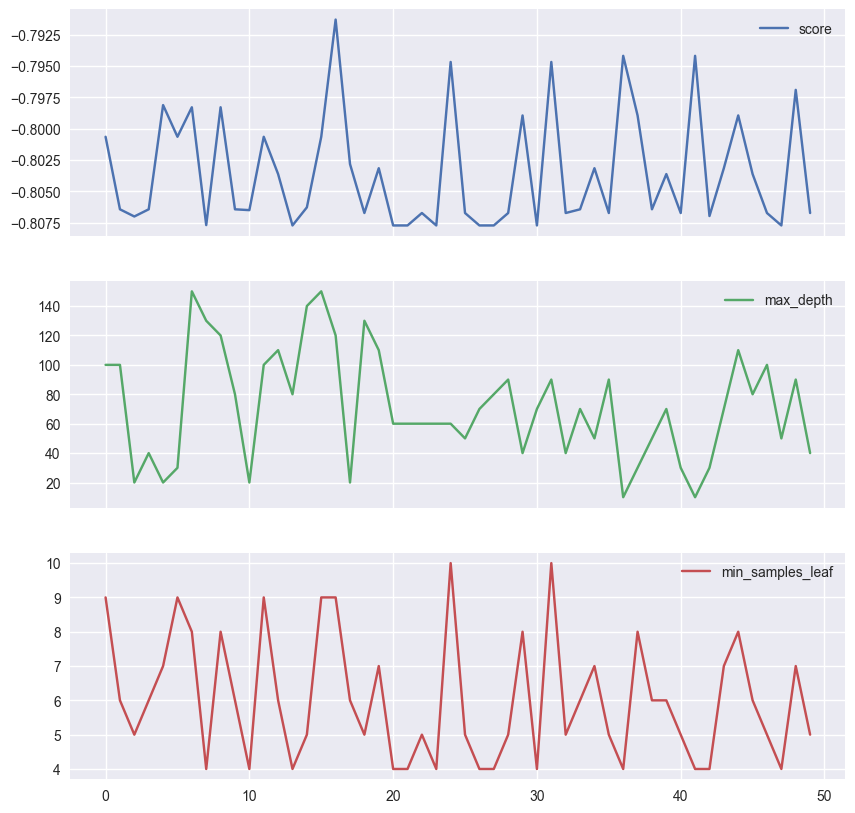

In [90]:
# Создадим массив нужных данных (оценку и гиперпараметры)
tpe_results_rf=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['min_samples_leaf'][0]]
                      for x in trials_rf.trials])

# Создадим ДФ
tpe_results_df=pd.DataFrame(tpe_results_rf,
                           columns=['score', 'max_depth', 'min_samples_leaf'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

#### Optuna

Произведем подбор гиперпараметров при помощи библиотеки Optuna для модели случайного леса. 

In [91]:

# Функция для оптимизации гиперпараметров для модели случайного леса
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # создаем модель
    model = ensemble.RandomForestClassifier(criterion=criterion,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=random_state)
    
    # Т.к. в данном методе кросс-валидации по умолчанию нет, 
    # пропишем ее вручную, с теми же параметрами, что и в других методах
    cv = KFold(n_splits=4, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
  
    return np.mean(scores)

In [92]:
# Заглушка для текстового вывода результатов работы каждой итерации оптимизации
optuna.logging.disable_default_handler()

# Начало работы оптимизации
start = time.time()

# cоздаем объект исследования, максимизируем метрику direction="maximize"
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=50, show_progress_bar=False);

# Время окончания работы оптимизации
end = time.time()

# Затраченное время
elapsed_time = round((end - start), 2)

In [93]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))
print(f'Затраченное время: {elapsed_time}')

Наилучшие значения гиперпараметров {'criterion': 'gini', 'max_depth': 19, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.81
Затраченное время: 189.43


In [94]:
# рассчитаем точность для тестовой выборки
model_optuna_rf = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state, )
model_optuna_rf.fit(X_train, y_train)
y_train_pred_optuns_rf = model_optuna_rf.predict(X_train)
print("f1_score на тренировочном наборе: {:.2f}".format(metrics.f1_score(y_train, y_train_pred_optuns_rf)))
y_test_pred_optuns_rf = model_optuna_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_optuns_rf)))

f1_score на тренировочном наборе: 0.99
f1_score на тестовом наборе: 0.83


In [95]:
# Занесение результатов данной работы в сводную таблицу
result_dict['ML_Model'].append('RandomForestClassifier')
result_dict['Optimisation_method'].append('Optuna')
result_dict['Best_params'].append(study_rf.best_params)
result_dict['Elapsed_time_sec'].append(elapsed_time)
result_dict['Iteration_count'].append(50)
result_dict['F1_Score_train'].append(round(
    metrics.f1_score(y_train, y_train_pred_optuns_rf), 2
    ))
result_dict['F1_Score_test'].append(round(
    metrics.f1_score(y_test, y_test_pred_optuns_rf), 2
    ))

Визуализируем результаты оптимизации. 

Первым построим диаграмму для проверки верности направления (в нашей случае метрика должна максимизироваться).

In [96]:
optuna.visualization.plot_optimization_history(study_rf, target_name="f1_score")

Все корректно, метрика растет. 

Теперь проверим какие гиперпараметры играют бОльшую значимость для метрики.

In [97]:
optuna.visualization.plot_param_importances(study_rf, target_name="f1_score")

Мы видим, что самый важный параметр - это минимальное количество экземпляров на листе дерева. 

Построим график для двух важных параметров, иллюстрирующую взаимосвязь параметров и метрики, min_samples_leaf и max_depth.

In [98]:
optuna.visualization.plot_contour(study_rf, params=["min_samples_leaf", "max_depth"],
                                  target_name="f1_score")

## Изучение результатов методов оптимизации гиперпараметров

И так, мы закончили подборы гиперпараметров, все данные свели в один словарь. 

Теперь мы можем изучить результат работы различных методов. 

Для этого преобразуем словарь в табличную форму.

In [105]:
result_df = pd.DataFrame.from_dict(result_dict)

display(result_df)

,ML_Model,Optimisation_method,Best_params,Elapsed_time_sec,Iteration_count,F1_Score_train,F1_Score_test
0,LogisticRegression,GridSearchCV_1,"{'penalty': 'l1', 'solver': 'saga'}",125.98,52,0.87,0.79
1,LogisticRegression,GridSearchCV_2,{'C': 0.5454545454545455},514.47,48,0.86,0.79
2,LogisticRegression,GridSearchCV_3,{'C': 0.5181818181818182},531.49,48,0.85,0.80
3,LogisticRegression,RandomizedSearchCV,"{'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.09...",625.81,50,0.85,0.80
4,LogisticRegression,Hyperopt,"{'penalty': None, 'solver': 'lbfgs', 'C': 0.17...",92.40,50,0.91,0.78
5,LogisticRegression,Optuna,"{'solver': 'sag', 'C': 0.060000000000000005, '...",261.16,50,0.84,0.80
6,RandomForestClassifier,GridSearchCV,"{'criterion': 'entropy', 'max_depth': 27, 'min...",75.29,45,0.95,0.82
7,RandomForestClassifier,GridSearchCV_2,"{'criterion': 'entropy', 'max_depth': 30, 'min...",70.72,48,1.00,0.83
8,RandomForestClassifier,RandomizedSearchCV,"{'min_samples_leaf': 1, 'max_depth': 110, 'cri...",53.81,50,1.00,0.83
9,RandomForestClassifier,Hyperopt,"{'criterion': 1, 'max_depth': 80.0, 'min_sampl...",128.52,50,0.96,0.82


Посчитаем временные затраты

In [117]:
elapsed_time_lr = result_df[result_df['ML_Model'] == 'LogisticRegression']['Elapsed_time_sec'].sum()
elapsed_time_rf = result_df[result_df['ML_Model'] == 'RandomForestClassifier']['Elapsed_time_sec'].sum()

print('Суммарное время работы методов оптимизации модели на базе логистической регрессии = {} минут {} секунд'.format(
    int(elapsed_time_lr//60), int(round(elapsed_time_lr%60))
    ))

print('Суммарное время работы методов оптимизации модели на базе случайного леса = {} минут {} секунд'.format(
    int(elapsed_time_rf//60), int(round(elapsed_time_rf%60))
    ))

Суммарное время работы методов оптимизации модели на базе логистической регрессии = 35 минут 51 секунд
Суммарное время работы методов оптимизации модели на базе случайного леса = 8 минут 38 секунд


**Вывод:**

Что можно сказать из полученных результатов. Во-первых, такая модель машинного обучение как случайный лес справилась с предсказаниями категориального признака лучше, чем модель на базе логистической регрессии. Ее наихудшая метрика выше, чем наилучшая у регрессии на 0.02. 

Время, затраченное на все способы оптимизации в случае логистической регрессии более чем в 4 раза превышает время, затраченное на оптимизацию случайного леса. 

В случае модели случайного леса почти все способы оптимизации показали себя хорошо, с точки зрения результатов метрики на тестовой выборке. Однако, метод RandomizedSearchCV потратил меньше всего времени. Остальные методы, не вдавайсь в подробности затратили от 2 до 3 минут. 

Однако, вернемся к изначальным метрикам, полученным при обучении и применении моделей с гиперпараметрами по умолчанию. 

<u><b>Метрики для моделей с гиперпараметрами по умолчанию:</b></u>

Для логистической регрессии:

- F1-score для тренировочной выборки составляет 0.89
- F1-score для тестовой выборки составляет 0.79

Для случайного леса: 

- F1-score для тренировочной выборки составляет 1.00
- F1-score для тестовой выборки составляет 0.83

<u><b>Лучшие метрики для моделей после подбора гиперпараметров:</b></u>

Для логистической регрессии:

- F1-score для тренировочной выборки составляет 0.85
- F1-score для тестовой выборки составляет 0.80

Для случайного леса: 

- F1-score для тренировочной выборки составляет 1.00
- F1-score для тестовой выборки составляет 0.83


Мы видим, что только в случае логистической регрессии удалось лишь немного нарастить метрику по тестовой выборке на 0.01. Таким образом, можно заключить, что в данном конкретном случае подбор гиперпараметров не дал на ни каких существенных улучшений. 